#Libraries, Dates and Data

In [1]:
#installing libraries
!pip install yfinance
!pip install tfcausalimpact

In [2]:
#import libraries
import yfinance as yf
from causalimpact import CausalImpact

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Dates
training_start = "2014-01-08"
training_end = "2015-08-26"
treatment_start = "2015-09-02"
treatment_end = "2015-09-30"
end_stock = "2015-10-02"

In [4]:
# Download historical VW (Volkswagen) stock data with weekly intervals
y = ["VOW.DE"]  # Ticker symbol for VW (Volkswagen)

y = yf.download(tickers=y,
                start=training_start,  # Start date for historical data
                end=end_stock,         # End date for historical data
                interval="1wk")        # Weekly interval

# Select adjusted close prices and rename column to 'y'
y = y['Adj Close'].rename("y")
# Display the first row of the data
y.head(1)

[*********************100%%**********************]  1 of 1 completed


Date
2014-01-06    117.486755
Name: y, dtype: float64

In [5]:
# Dowload the control groups
stocks = ["META", "DIS", "NVS", "AMZ"] # List of stock tickers

X = yf.download(tickers=stocks,
                start=training_start,  # Start date for historical data
                end=end_stock,         # End date for historical data
                interval="1wk")        # Weekly interval

# Select only the relevant columns and remove multi-level column headers
X = X.iloc[:,:len(stocks)]
X.columns = X.columns.droplevel()
X.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,AMZ,DIS,META,NVS
Date,,,,
2014-01-06,290.200012,68.839668,57.821182,48.912113
2014-01-13,296.000000,67.552162,56.184544,48.815899
2014-01-20,287.000000,66.401649,54.338337,48.010124
2014-01-27,271.299988,66.301208,62.441685,47.547096
2014-02-03,260.450012,69.095322,64.188103,48.659550


In [6]:
# Combine the VW stock data with other stock data and remove any rows with missing values
X.index = X.index.tz_localize(None)  # Remove timezone information from the index

# Concatenate VW data with other stock data and drop rows with any missing values
df = pd.concat([y, X], axis=1).dropna()
df.head()

,y,AMZ,DIS,META,NVS
Date,,,,,
2014-01-06,117.486755,290.200012,68.839668,57.821182,48.912113
2014-01-13,118.963623,296.000000,67.552162,56.184544,48.815899
2014-01-20,111.518974,287.000000,66.401649,54.338337,48.010124
2014-01-27,108.715919,271.299988,66.301208,62.441685,47.547096
2014-02-03,110.011948,260.450012,69.095322,64.188103,48.659550


#Correlation Matrix

In [7]:
# Subset the training data
df_training = df[df.index <= training_end]
df_training.tail()

,y,AMZ,DIS,META,NVS
Date,,,,,
2015-07-13,127.579147,445.350006,110.551414,94.775246,67.631142
2015-07-27,115.840866,484.250000,111.611732,93.817215,66.314445
2015-08-10,113.291817,478.299988,99.669281,94.226372,65.502701
2015-08-17,103.850815,445.049988,91.930862,85.883507,62.357948
2015-08-24,107.312515,465.399994,95.316414,90.823372,62.862892


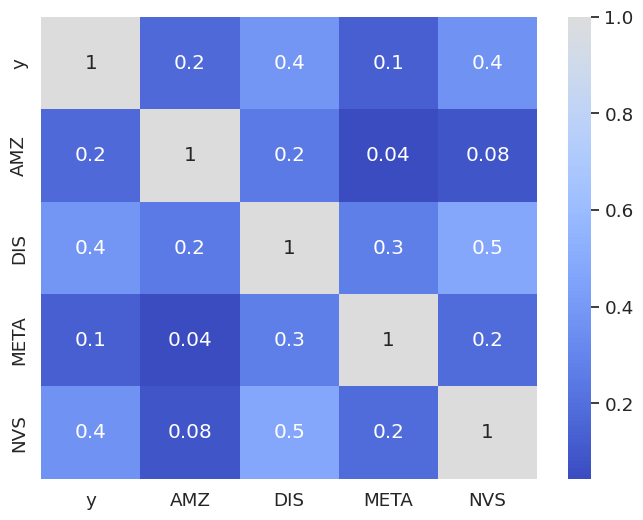

In [8]:
# Plot a heatmap of the correlation matrix for percentage changes in the training data
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

sns.heatmap(data=df_training.pct_change().dropna().corr(),  # Compute and plot the correlation matrix of percentage changes
            annot=True,                                     # Annotate each cell with the correlation value
            fmt='.1g',                                      # Format for annotation text
            cmap='coolwarm',                                # Colormap for the heatmap
            center=True)                                    # Center the colormap at a value (usually 0)

# Display
plt.show()


In [10]:
# Preparing final df
df_final = df.drop(columns = ["META", "AMZ"])
df_final.head(1)

,y,DIS,NVS
Date,,,
2014-01-06,117.486755,68.839668,48.912113


#Google Causal Impact

In [11]:
# Get first and last date
print(df_final.head(1))
print(df_final.tail(10))

                     y        DIS        NVS
Date                                        
2014-01-06  117.486755  68.839668  48.912113
                     y         DIS        NVS
Date                                         
2015-07-13  127.579147  110.551414  67.631142
2015-07-27  115.840866  111.611732  66.314445
2015-08-10  113.291817   99.669281  65.502701
2015-08-17  103.850815   91.930862  62.357948
2015-08-24  107.312515   95.316414  62.862892
2015-08-31  100.672340   93.911964  60.434032
2015-09-07  104.637558   97.176628  61.712368
2015-09-14  101.553528   95.651253  61.776302
2015-09-21   72.727051   93.288811  58.363098
2015-09-28   63.663692   95.800064  59.615879


In [12]:
#Dates
training_start = "2014-01-06"
training_end = "2015-08-31"
treatment_start = "2015-09-07"
treatment_end = "2015-09-28"
end_stock = "2015-10-02"

In [13]:
# Define Pre and Post Period
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

In [14]:
# Apply the Google Causal Impact analysis to the data
impact = CausalImpact(data=df_final,          # Data containing the time series
                      pre_period=pre_period,  # Period before the intervention
                      post_period=post_period) # Period after the intervention

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


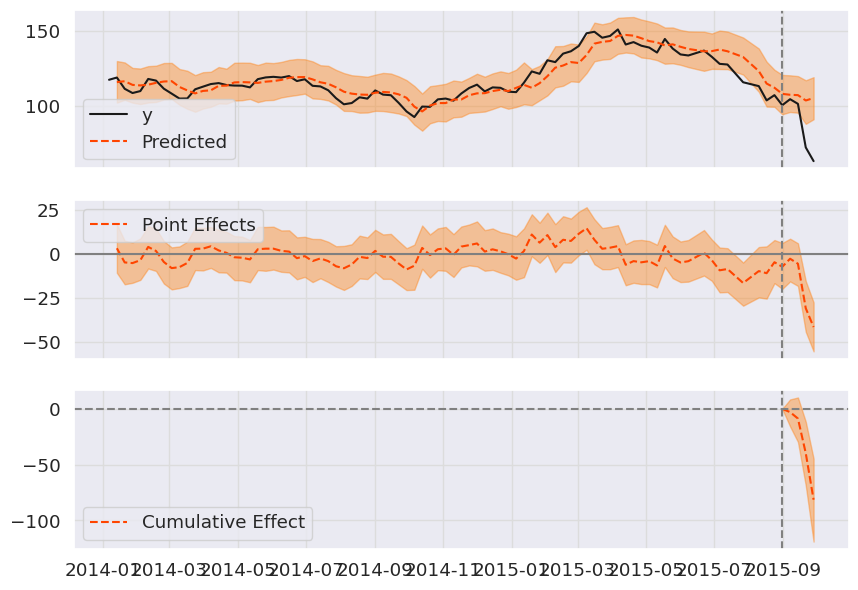

In [15]:
# Plot the results of the Causal Impact analysis
impact.plot()

In [16]:
# Summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    85.65              342.58
Prediction (s.d.)         106.01 (5.19)      424.06 (20.77)
95% CI                    [95.7, 116.06]     [382.81, 464.22]

Absolute effect (s.d.)    -20.37 (5.19)      -81.48 (20.77)
95% CI                    [-30.41, -10.06]   [-121.64, -40.23]

Relative effect (s.d.)    -19.21% (4.9%)     -19.21% (4.9%)
95% CI                    [-28.68%, -9.49%]  [-28.68%, -9.49%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))
